**Stock Prediction RNN**

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict Apple's stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a Long Term Short Memory (LTSM), which helps significantly avoid technical problems with optimization of RNNs.

# Pytorch LSTM Stock Predictor

This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/), and also available elsewhere in this repo as a notebook.

#  1. Loading Data

load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [ ]:
#download the data
!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

--2022-09-02 03:10:45--  https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/plain]
Saving to: ‘all_stocks_5yr.csv’

all_stocks_5yr.csv  100%[===================>]  28.21M  --.-KB/s    in 0.08s   

2022-09-02 03:10:46 (343 MB/s) - ‘all_stocks_5yr.csv’ saved [29580549/29580549]



In [ ]:
!ls

all_stocks_5yr.csv  sample_data


In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [ ]:
#importing the training set
ds = data = pd.read_csv('./all_stocks_5yr.csv')
ds_cl = ds[ds['Name']=='SWKS'].close.values #close

In [ ]:
ds_cl

array([ 23.93,  24.25,  24.2 , ...,  94.68, 104.56, 101.35])

In [ ]:
#feature scaling
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler(feature_range=(0,1))

In [ ]:
#scale the data
ds_cl = ds_cl.reshape(ds_cl.shape[0],1)
ds_cl = mms.fit_transform(ds_cl)

In [ ]:
ds_cl

array([[0.03930131],
       [0.04262841],
       [0.04210855],
       ...,
       [0.77490123],
       [0.87762529],
       [0.84425036]])

# 2.Cutting time series into sequences

In [ ]:
#slice data each 7 days
def slicedata(data,back):
    X, Y = [], []
    for i in range(len(data) - back - 1):
      X.append(data[i: (i + back),0])
      Y.append(data[(i + back),0])
    return np.array(X), np.array(Y)
X, y = slicedata(ds_cl,7)

In [ ]:
X.shape[0]

1251

# 3.Split training and testing sets

In [ ]:
#select 2/3 of data as training set, and the later chunck as test
X_train, X_test = X[:int(X.shape[0]*0.8)], X[int(X.shape[0]*0.8):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]


In [ ]:
#check the shape
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

1000
251
1000
251


In [ ]:
X_train

array([[0.03930131, 0.04262841, 0.04210855, ..., 0.05011437, 0.0452277 ,
        0.04564358],
       [0.04262841, 0.04210855, 0.04314826, ..., 0.0452277 , 0.04564358,
        0.03607819],
       [0.04210855, 0.04314826, 0.05011437, ..., 0.04564358, 0.03607819,
        0.01050114],
       ...,
       [0.74568517, 0.73674361, 0.74714078, ..., 0.74433354, 0.74433354,
        0.73778332],
       [0.73674361, 0.74714078, 0.75733001, ..., 0.74433354, 0.73778332,
        0.74246205],
       [0.74714078, 0.75733001, 0.74433354, ..., 0.73778332, 0.74246205,
        0.74069453]])

In [ ]:
# reshape 2d--3d
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train

array([[[0.03930131, 0.04262841, 0.04210855, ..., 0.05011437,
         0.0452277 , 0.04564358]],

       [[0.04262841, 0.04210855, 0.04314826, ..., 0.0452277 ,
         0.04564358, 0.03607819]],

       [[0.04210855, 0.04314826, 0.05011437, ..., 0.04564358,
         0.03607819, 0.01050114]],

       ...,

       [[0.74568517, 0.73674361, 0.74714078, ..., 0.74433354,
         0.74433354, 0.73778332]],

       [[0.73674361, 0.74714078, 0.75733001, ..., 0.74433354,
         0.73778332, 0.74246205]],

       [[0.74714078, 0.75733001, 0.74433354, ..., 0.73778332,
         0.74246205, 0.74069453]]])

# 4.Build and run RNN regression model

In [ ]:
# build model

class RNN(nn.Module):
  def __init__(self, i_size, h_size, n_layers, o_size, dropout =0.1, bidirectional =True):
    super(RNN, self).__init__()
    self.num_directions = bidirectional + 1
    self.rnn = nn.LSTM(
        input_size=i_size,
        hidden_size=h_size,
        num_layers=n_layers,
        dropout=dropout,
        bidirectional=bidirectional
      )
    self.out = nn.Linear(h_size, o_size)
  
  def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state   

In [ ]:
#set globals

Input_size = 7
Hidden_size = 64
Num_layers = 3
Output_size = 1
Batch_size = 128

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# hyper parameters
learning_rate = 0.001
num_epochs = 300

rnn = RNN(Input_size,Hidden_size,Num_layers,Output_size,bidirectional = False)
rnn.cuda()



RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
optimiser =  torch.optim.Adam(rnn.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [ ]:
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

In [ ]:
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

In [ ]:
for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters
    
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.21793322265148163, eval loss 0.6312540173530579
epoch 1, loss 0.19734418392181396
epoch 2, loss 0.1786428540945053
epoch 3, loss 0.1607620269060135
epoch 4, loss 0.1433761864900589
epoch 5, loss 0.1260119378566742
epoch 6, loss 0.10814819484949112
epoch 7, loss 0.08927536010742188
epoch 8, loss 0.07141607999801636
epoch 9, loss 0.05466269329190254
epoch 10, loss 0.04268650338053703
epoch 11, loss 0.04435531049966812
epoch 12, loss 0.058602869510650635
epoch 13, loss 0.06187489256262779
epoch 14, loss 0.05314197763800621
epoch 15, loss 0.043342478573322296
epoch 16, loss 0.0365867093205452
epoch 17, loss 0.03492678701877594
epoch 18, loss 0.034894052892923355
epoch 19, loss 0.03547785431146622
epoch 20, loss 0.034904833883047104, eval loss 0.10741881281137466
epoch 21, loss 0.03391740843653679
epoch 22, loss 0.031825222074985504
epoch 23, loss 0.02758507989346981
epoch 24, loss 0.023577747866511345
epoch 25, loss 0.018874898552894592
epoch 26, loss 0.016068974509835243
e

In [ ]:
rnn.out.weight 

Parameter containing:
tensor([[ 0.0146, -0.0704, -0.1098,  0.0585, -0.0641,  0.0420, -0.0850, -0.0278,
         -0.0126,  0.0552,  0.0179,  0.0239,  0.0249, -0.0207,  0.0402,  0.0980,
          0.0568,  0.0190, -0.0743,  0.0045, -0.1276,  0.0703,  0.0474,  0.1023,
         -0.1202,  0.0758,  0.0590,  0.1076,  0.1246, -0.0181,  0.0960,  0.0134,
         -0.0367,  0.0928, -0.0404,  0.0659,  0.1182,  0.0359, -0.0458,  0.0547,
          0.1150,  0.0329, -0.0246, -0.0248,  0.0672, -0.0206,  0.1156,  0.0127,
          0.0854, -0.0098,  0.0954, -0.0110, -0.0711,  0.0817,  0.0886,  0.0536,
         -0.1094,  0.1162, -0.0045, -0.0333,  0.0185, -0.0265, -0.0801, -0.1197]],
       device='cuda:0', requires_grad=True)

In [ ]:
for param in rnn.parameters():
    print(param.data)

tensor([[ 0.1418, -0.0753, -0.0560,  ..., -0.0437,  0.0789,  0.1489],
        [ 0.0440,  0.1231,  0.0576,  ...,  0.0730,  0.0897, -0.1022],
        [-0.0071,  0.0239,  0.0080,  ..., -0.0504, -0.0768, -0.0351],
        ...,
        [-0.0207,  0.0831,  0.0885,  ..., -0.0837, -0.0101,  0.1399],
        [ 0.1356, -0.0248, -0.0782,  ..., -0.0476,  0.0665,  0.0155],
        [-0.0686, -0.0085,  0.1494,  ..., -0.0580, -0.0508,  0.0923]],
       device='cuda:0')
tensor([[-0.0599,  0.0513, -0.0582,  ..., -0.1144, -0.0215,  0.0295],
        [-0.1123,  0.0531,  0.0726,  ...,  0.1132, -0.0406, -0.0036],
        [ 0.0500,  0.0349,  0.1278,  ...,  0.0403, -0.0682, -0.0300],
        ...,
        [ 0.0199,  0.0909, -0.0629,  ...,  0.0990, -0.1040, -0.0896],
        [-0.0522,  0.0922, -0.1183,  ..., -0.0711, -0.0909,  0.0649],
        [-0.0717,  0.0836, -0.1347,  ...,  0.0435,  0.0543, -0.0087]],
       device='cuda:0')
tensor([-0.0578, -0.1321, -0.0192,  0.0188, -0.0199, -0.1100,  0.0798, -0.0044,
    

# 5.checking model performance

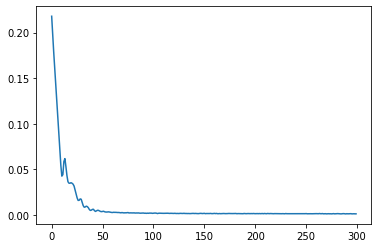

In [ ]:
plt.plot(history)

In [ ]:
X_test[0]

array([[0.75733001, 0.74433354, 0.74433354, 0.73778332, 0.74246205,
        0.74069453, 0.74474943]])

In [ ]:
rnn.eval()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [ ]:
test_predict_cpu.shape

(251, 1, 1)

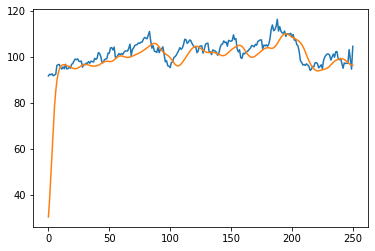

In [ ]:
plt.plot(mms.inverse_transform(y_test.reshape(-1,1)))
plt.plot(mms.inverse_transform(test_predict_cpu.reshape(-1,1)))

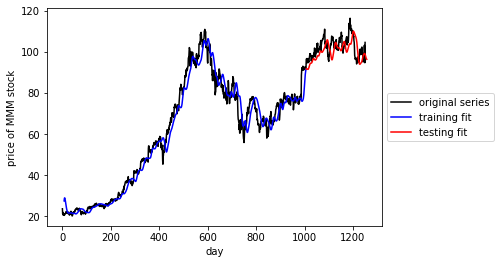

In [ ]:
# plot original data
plt.plot(mms.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), mms.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), mms.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()